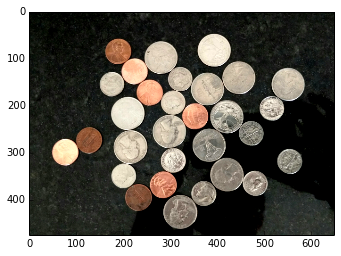

In [1]:
import matplotlib.pyplot as plt
from skimage import color, feature
%matplotlib inline


im = plt.imread('sample-images/quarters_dimes_pennies.png')
gray_im = color.rgb2gray(im)
plt.imshow(im)


The coins are much brighter than the background, so let's create a mask for the coins. Use li's method to automatically determine the correct threshold.

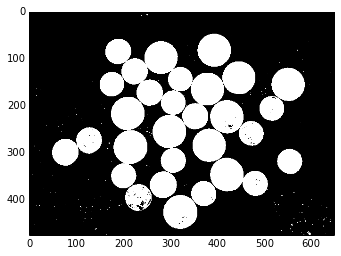

In [2]:
from skimage.filters import threshold_li

coin_thresh = threshold_li(gray_im)
coin_mask = gray_im > coin_thresh
plt.imshow(coin_mask, cmap='gray')

There is some noise, use morphology operators to clean up the mask. 

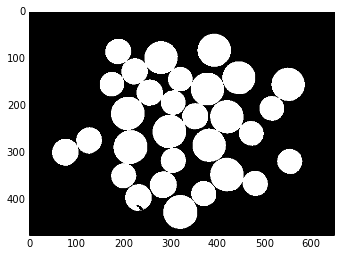

In [3]:
from skimage import morphology
from skimage.morphology import disk

coin_mask_clean = morphology.remove_small_objects(coin_mask)
coin_mask_clean = morphology.remove_small_objects(~coin_mask_clean)

plt.imshow(~coin_mask_clean, cmap='gray')

While not 100% perfect, it's close enough, and we will use this mask going forward. Use the coin mask that you created to set the background of the original color image to black, and display display it. You should be able to see the coins in color, but the counter (and the reflections in the counter should be black). While you're at it, set the background of the grayscale image to zero as well. From now on, we don't have to worry about the background affecting our results because we've masked it out.

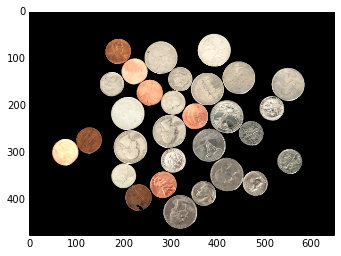

In [4]:
im[coin_mask_clean] = 0
gray_im[coin_mask_clean] = 0
plt.imshow(im)

Now that we've segmented the foreground from the background, we want to distinguish the coins from each other. Use the watershed-based segmentation that was introduced in the cell counting demo. Print the number of coins in the image. 

There are 30 coins in the image.


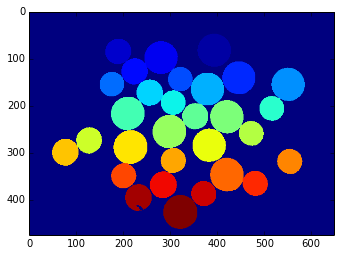

In [5]:
from scipy import ndimage as ndi
from skimage import measure
import numpy as np

def watershed_segmentation(mask):
    distance_im = ndi.distance_transform_edt(~mask)
    peaks_im = feature.peak_local_max(distance_im, indices=False)
    markers_im = measure.label(peaks_im)
    labelled_im = morphology.watershed(-distance_im, markers_im, mask=~coin_mask_clean)
    return labelled_im


labelled_coin_im = watershed_segmentation(coin_mask_clean)

print 'There are %i coins in the image.' % (len(np.unique(labelled_coin_im)) - 1)
plt.imshow(labelled_coin_im);


Look up the documentation for scikit-image function `regionprops` online. Use this function with the labelled coins image to compute the area of each coin and the location of each coin's center (called the "centroid"). `imshow` the original image and use matplotlib's `text` function to label each coin with its area.

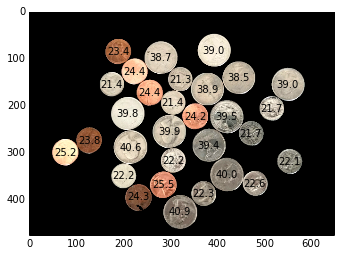

In [7]:
regions = measure.regionprops(labelled_coin_im)

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    area_str = '%.1f' % (area/100)
    plt.text(x, y, area_str, color='k', ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment

It is possible to separate the coins on the basis of size. Play with different size thresholds and see if you can separate the regions (the output of `regionprops`) by size in order to identify the coins.

Total value of coins is $4.08


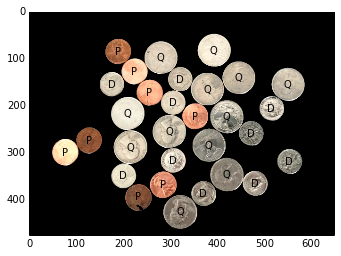

In [18]:

max_dime_area = 2300
min_quarter_area = 3800
value = 0.

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    if area <= max_dime_area:
        coin_name = 'D'
        value += 10
    elif area >= min_quarter_area:
        coin_name = 'Q'
        value += 25
    else:
        coin_name = 'P'
        value += 1
    plt.text(x, y, coin_name, ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment
    
print 'Total value of coins is $%.2f' % (value/100)

In [ ]:


from scipy.signal import fftconvolve  # fftconvolve is usually much faster than plain convolve (they do the same thing)
import numpy as np

# difference of gaussians


im = plt.imread('sample-images/coins.png')
gray_im = color.rgb2gray(im)

    
for sigma1 in range(14, 36, 2):
    
#     sigma1 = 13.
    sigma2 = 1.5*sigma1
    kern_sz = 3*sigma2

    x, y = np.mgrid[-kern_sz/2+1:kern_sz/2+1, -kern_sz/2+1:kern_sz/2+1]
    rsqr = x**2 + y**2
    gaussian1 = np.exp(-rsqr/sigma1**2)/sigma1
    gaussian2 = np.exp(-rsqr/sigma2**2)/sigma2
    dog_kern = gaussian1 - gaussian2
    dog_kern -= dog_kern.mean()

    blob_im = fftconvolve(gray_im, -dog_kern, mode='same')
    blob_im[blob_im<0] = 0
    
    plt.figure()
    plt.imshow(blob_im, cmap='gray')
    plt.title('sigma = %i' % sigma1)

The dimes and pennies are closer to each other in size, but the pennies have a copper color. Let's try to use the color of the pennies to select them. 

In [ ]:
hsv = color.rgb2hsv(im)
plt.figure()
plt.imshow(hsv[..., 1], cmap='gray')
plt.title('saturation')

# sat_thresh = 0.3
sat_thresh = threshold_otsu(hsv[..., 1])
plt.figure()
plt.imshow(hsv[..., 1]>sat_thresh, cmap='gray')
plt.title('saturation')

In [ ]:
plt.imshow(im[...,0], cmap='gray')
plt.title('red')

plt.figure()
plt.imshow(im[...,1], cmap='gray')
plt.title('blue')

plt.figure()
plt.imshow(im[...,2], cmap='gray')
plt.title('green')


In [ ]:
hsv = color.rgb2hsv(im)
plt.imshow(hsv[...,1], cmap='gray')


According to the documentation of the scikit-image's blob detector functions, the radius of each blob is approximately $r=\sqrt{2}\sigma$, or thus $\sigma=\frac{d}{2\sqrt{2}}$, where $d$ is the diamter. The small coins have a diameter of about $d=40$ or $d=50$, corresponding to $\sigma\approx14-18$. Make sure to make the kernel size large enough to encompass the whole coin! 

In [ ]:
import matplotlib.pyplot as  plt
from skimage import color
from scipy.signal import fftconvolve  # fftconvolve is usually much faster than plain convolve (they do the same thing)
import numpy as np
%matplotlib inline

im = plt.imread('sample-images/coins.png')
gray_im = color.rgb2gray(im)
    
    
for rval in range(18, 36, 2):
    
    kern_sz = 3*rval
    rmax = 1.5*rval
    x = np.linspace(-kern_sz/2, kern_sz/2, kern_sz)
    x, y = np.meshgrid(x, x)
    r = np.sqrt(x**2 + y**2)
    coin_kernel = -np.ones((kern_sz, kern_sz))
    coin_kernel[r<rval] = 1
    coin_kernel[r>rmax] = 0

    # nomalize
    mask = np.abs(coin_kernel) > 0
    coin_kernel[mask] -= coin_kernel[mask].mean()


    blob_im = fftconvolve(gray_im, -coin_kernel, mode='same')
    blob_im[blob_im<0] = 0

#     plt.figure()
#     plt.imshow(coin_kernel, cmap='gray')
#     plt.figure()
#     plt.imshow(gray_im, cmap='gray')
    plt.figure()
    plt.imshow(blob_im, cmap='gray')
    plt.title('radius %i' % rval)

In [ ]:
plt.imshow(gray_im, cmap='gray')

